In [1]:
# Import Libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder, MinMaxScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix, jaccard_score, log_loss
import itertools
import pickle
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Embedding, Flatten, Dense, Concatenate
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers import Adam

In [2]:
# Load data
df = pd.read_csv('events.csv')
df1 = pd.read_csv('category_tree.csv')
df2 = pd.read_csv('item_properties_part1.csv')
df3 = pd.read_csv('item_properties_part2.csv')

In [3]:
# Combine item properties
df_items = pd.concat([df2, df3], ignore_index=True)

In [4]:
# Convert timestamp to datetime
df['timestamp'] = pd.to_datetime(df['timestamp'], unit='ms', errors='coerce')
df_items['timestamp'] = pd.to_datetime(df_items['timestamp'], unit='ms', errors='coerce')

In [5]:
# Checking missing values
df.isnull().sum()

timestamp              0
visitorid              0
event                  0
itemid                 0
transactionid    2733644
dtype: int64

In [6]:
# Handle missing values
df.dropna(subset=['visitorid', 'event', 'itemid'], inplace=True)
df_items.dropna(subset=['itemid', 'property', 'value'], inplace=True)
df1.dropna(inplace=True)

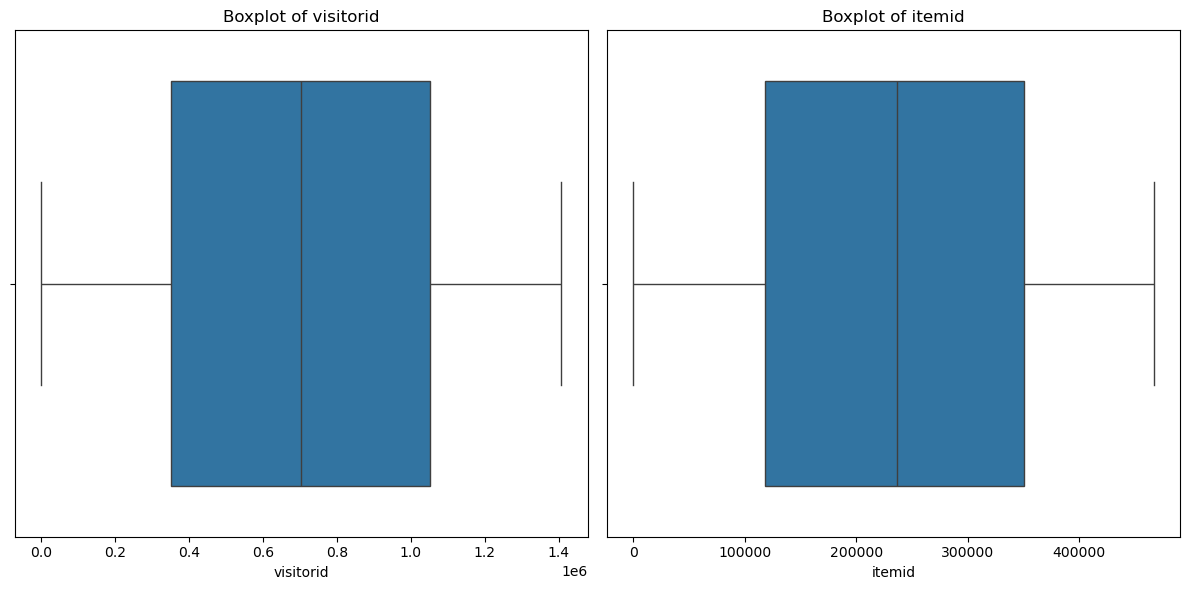

In [7]:
# Boxplots for outlier detection
numerical_features = ['visitorid', 'itemid']
plt.figure(figsize=(12, 6))
for i, feature in enumerate(numerical_features, 1):
    plt.subplot(1, len(numerical_features), i)
    sns.boxplot(x=df[feature])
    plt.title(f'Boxplot of {feature}')
    plt.tight_layout()
plt.show()

In [8]:
# Remove outliers using IQR
def remove_outliers(df, column):
    Q1 = df[column].quantile(0.25)
    Q3 = df[column].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    return df[(df[column] >= lower_bound) & (df[column] <= upper_bound)]

df = remove_outliers(df, 'visitorid')
df = remove_outliers(df, 'itemid')

In [9]:
# Data transformation
df_items['value'] = df_items['value'].astype(str)
df1['categoryid'] = df1['categoryid'].astype(str)
df_items = df_items.merge(df1, left_on='value', right_on='categoryid', how='left')
df_item_features = df_items.groupby('itemid').agg({'property': 'count'}).reset_index()
df_item_features.rename(columns={'property': 'num_properties'}, inplace=True)
df = df.merge(df_item_features, on='itemid', how='left')
df['num_properties'].fillna(0, inplace=True)

/var/folders/vg/blh32y9151b_cvxt1fhll78w0000gn/T/ipykernel_61711/1996272497.py:8: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df['num_properties'].fillna(0, inplace=True)


In [10]:
# Feature engineering
df['hour'] = df['timestamp'].dt.hour
df['day'] = df['timestamp'].dt.day
df['month'] = df['timestamp'].dt.month
df['weekday'] = df['timestamp'].dt.weekday

In [11]:
# Encoding categorical variables
le = LabelEncoder()
df['event'] = le.fit_transform(df['event'])

In [12]:
unique_visitor = df['visitorid'].nunique()
total_visitor = df['visitorid'].size

print(f'Total visitors: {total_visitor}')
print(f'Unique visitor: {unique_visitor}')

Total visitors: 2756101
Unique visitor: 1407580


In [13]:
# Check how many item customer purchased

customer_purchased = df[df['transactionid'].notnull()].visitorid.nunique()
customer_purchased

11719

#### So out of 1,407,580 visitors, only 11,719 bought something so around 1,395,861 visitors just viewed the items.

/var/folders/vg/blh32y9151b_cvxt1fhll78w0000gn/T/ipykernel_61711/3785400418.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=event_labels, y=event_counts.values, palette=['blue', 'orange', 'green'])


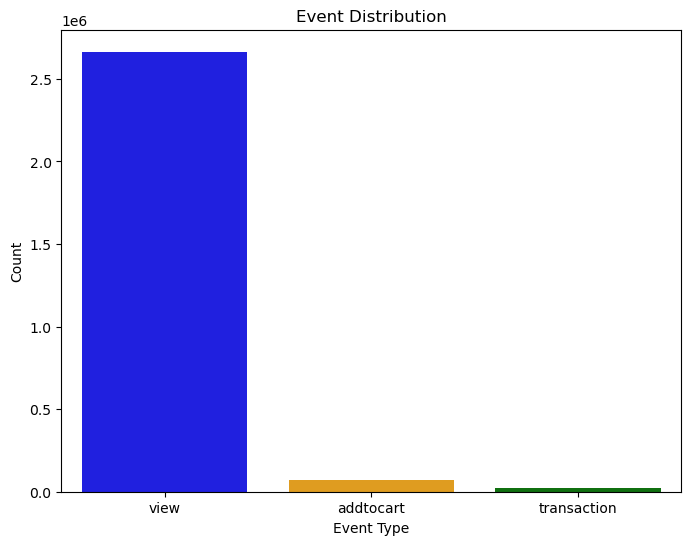

In [14]:
# Data Visualizations
# Event Distribution
plt.figure(figsize=(8, 6))
event_counts = df['event'].value_counts()
event_labels = le.inverse_transform(event_counts.index)
sns.barplot(x=event_labels, y=event_counts.values, palette=['blue', 'orange', 'green'])
plt.title('Event Distribution')
plt.xlabel('Event Type')
plt.ylabel('Count')
plt.xticks(rotation=0)
plt.show()

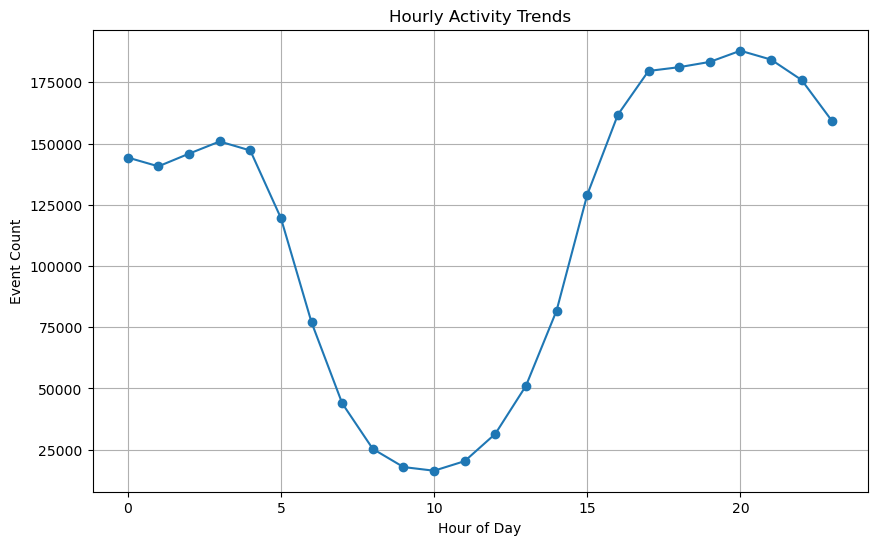

In [15]:
# Hourly Activity Trends
hourly_data = df.groupby('hour').size()
plt.figure(figsize=(10,6))
hourly_data.plot(marker='o')
plt.title('Hourly Activity Trends')
plt.xlabel('Hour of Day')
plt.ylabel('Event Count')
plt.grid(True)
plt.show()

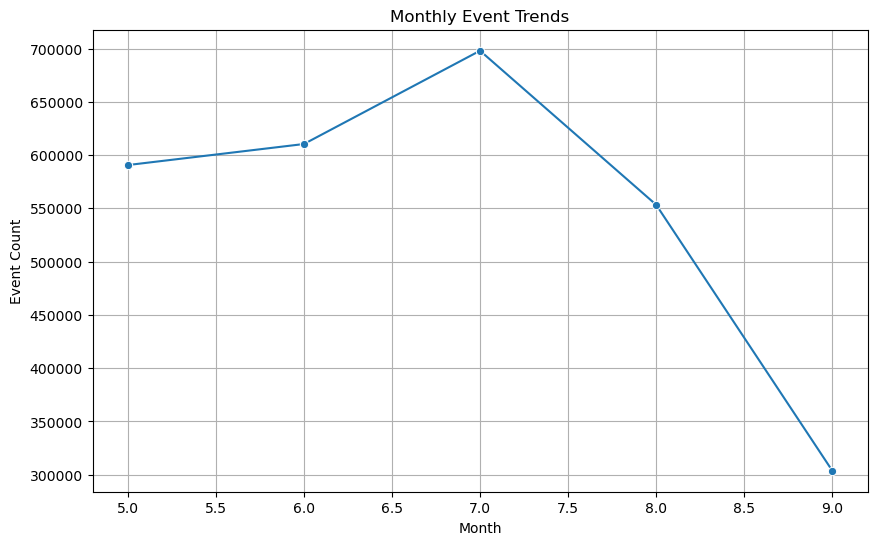

In [16]:
# Monthly Trends
monthly_data = df.groupby('month').size()
plt.figure(figsize=(10,6))
sns.lineplot(x=monthly_data.index, y=monthly_data.values, marker='o')
plt.title('Monthly Event Trends')
plt.xlabel('Month')
plt.ylabel('Event Count')
plt.grid(True)
plt.show()

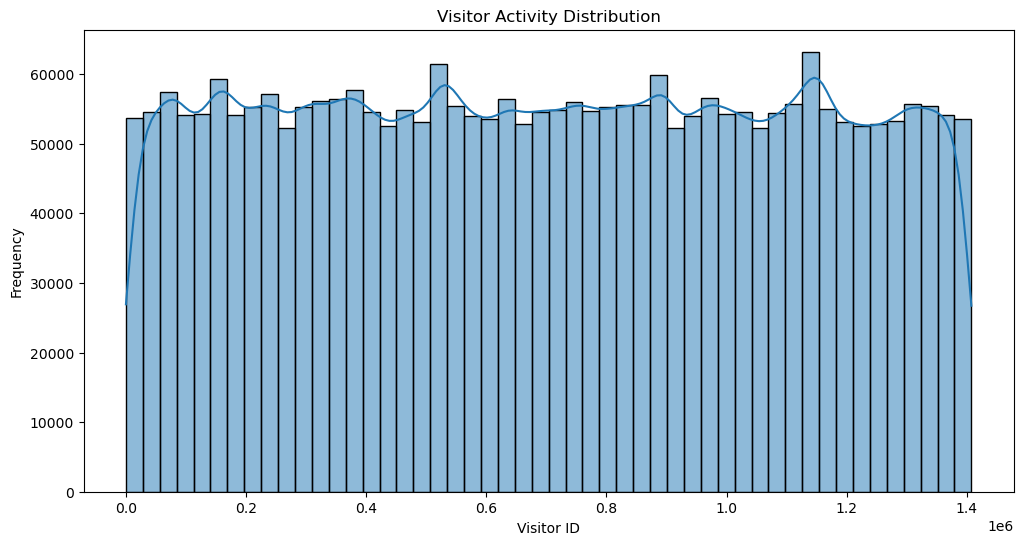

In [17]:
# Visitor Activity
plt.figure(figsize=(12,6))
sns.histplot(df['visitorid'], bins=50, kde=True)
plt.title('Visitor Activity Distribution')
plt.xlabel('Visitor ID')
plt.ylabel('Frequency')
plt.show()

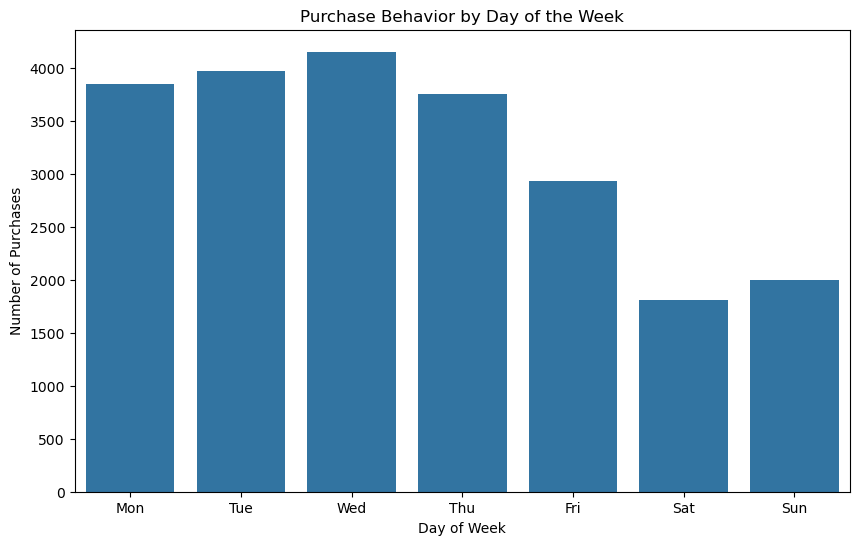

In [18]:
purchase_data = df[df['event'] == le.transform(['transaction'])[0]].groupby('weekday').size()
plt.figure(figsize=(10,6))
sns.barplot(x=['Mon','Tue','Wed','Thu','Fri','Sat','Sun'], y=purchase_data.values)
plt.title('Purchase Behavior by Day of the Week')
plt.xlabel('Day of Week')
plt.ylabel('Number of Purchases')
plt.show()

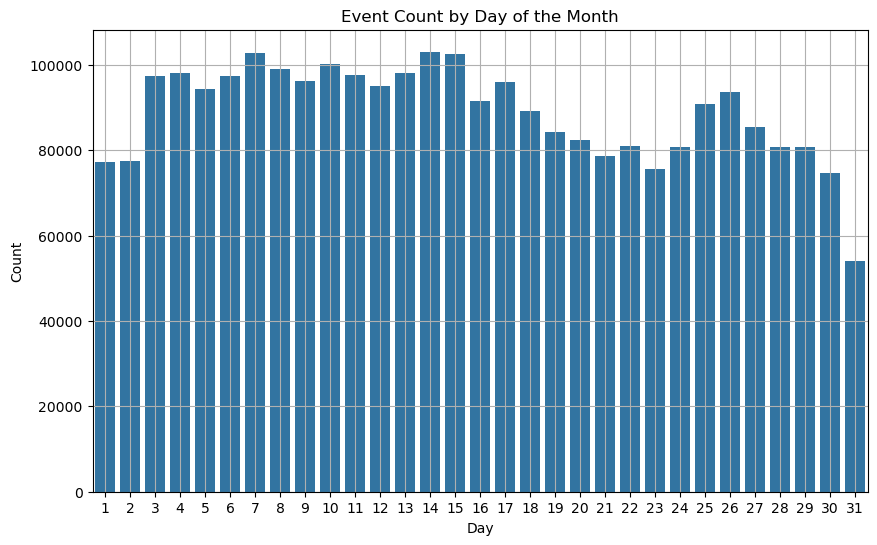

In [19]:
# Countplot of events over different days
plt.figure(figsize=(10, 6))
sns.countplot(x='day', data=df)
plt.title('Event Count by Day of the Month')
plt.xlabel('Day')
plt.ylabel('Count')
plt.grid(True)
plt.show()

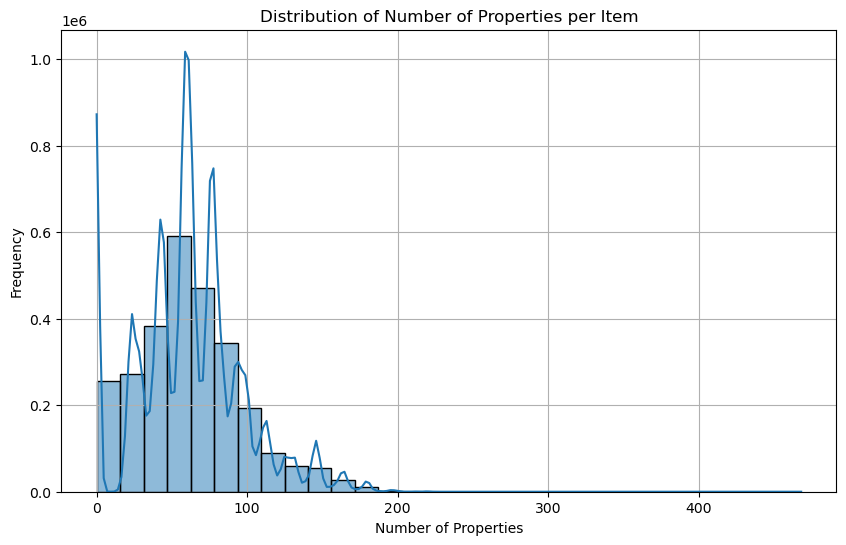

In [20]:
# Distribution of number of properties per item
plt.figure(figsize=(10, 6))
sns.histplot(df['num_properties'], bins=30, kde=True)
plt.title('Distribution of Number of Properties per Item')
plt.xlabel('Number of Properties')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()

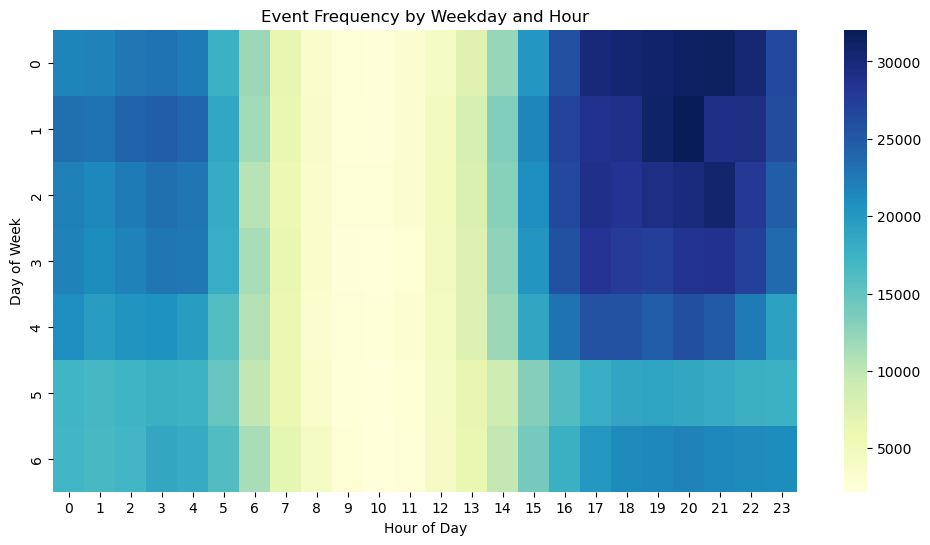

In [21]:
# Heatmap of events per weekday and hour
event_matrix = df.pivot_table(index='weekday', columns='hour', values='event', aggfunc='count')
plt.figure(figsize=(12, 6))
sns.heatmap(event_matrix, cmap='YlGnBu')
plt.title('Event Frequency by Weekday and Hour')
plt.xlabel('Hour of Day')
plt.ylabel('Day of Week')
plt.show()

In [22]:
# Define features and target
X = df[['visitorid', 'itemid', 'hour', 'day', 'month', 'weekday', 'num_properties']]
y = df['event']

In [23]:
# Split dataset
def split_data(X, y):
    return train_test_split(X, y, test_size=0.2, random_state=42)

X_train, X_test, y_train, y_test = split_data(X, y)

In [24]:
# Scale data
def scale_data(X_train, X_test):
    scaler = StandardScaler()
    return scaler.fit_transform(X_train), scaler.transform(X_test), scaler

X_train_scaled, X_test_scaled, scaler = scale_data(X_train, X_test)

In [25]:
# Train models individually
def train_random_forest(X_train, y_train):
    model = RandomForestClassifier(n_estimators=100, random_state=42)
    model.fit(X_train, y_train)
    return model

def train_decision_tree(X_train, y_train):
    model = DecisionTreeClassifier(criterion='entropy', max_depth=4)
    model.fit(X_train, y_train)
    return model

def train_knn(X_train, y_train, n_neighbors=7):
    model = KNeighborsClassifier(n_neighbors=n_neighbors)
    model.fit(X_train, y_train)
    return model

rf_model = train_random_forest(X_train_scaled, y_train)
dt_model = train_decision_tree(X_train_scaled, y_train)
knn_model = train_knn(X_train_scaled, y_train)

In [26]:
# Evaluate model
def evaluate_model(model, X_test, y_test):
    y_pred = model.predict(X_test)
    print(f"Accuracy: {accuracy_score(y_test, y_pred) * 100:.2f}%")
    print(classification_report(y_test, y_pred))
    return y_pred

y_pred_rf = evaluate_model(rf_model, X_test_scaled, y_test)
y_pred_dt = evaluate_model(dt_model, X_test_scaled, y_test)
y_pred_knn = evaluate_model(knn_model, X_test_scaled, y_test)

Accuracy: 95.55%
              precision    recall  f1-score   support

           0       0.12      0.07      0.09     13967
           1       0.02      0.01      0.02      4481
           2       0.97      0.99      0.98    532773

    accuracy                           0.96    551221
   macro avg       0.37      0.35      0.36    551221
weighted avg       0.94      0.96      0.95    551221

Accuracy: 96.65%


/opt/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/opt/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/opt/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


              precision    recall  f1-score   support

           0       0.00      0.00      0.00     13967
           1       0.00      0.00      0.00      4481
           2       0.97      1.00      0.98    532773

    accuracy                           0.97    551221
   macro avg       0.32      0.33      0.33    551221
weighted avg       0.93      0.97      0.95    551221

Accuracy: 96.60%
              precision    recall  f1-score   support

           0       0.33      0.02      0.04     13967
           1       0.08      0.00      0.00      4481
           2       0.97      1.00      0.98    532773

    accuracy                           0.97    551221
   macro avg       0.46      0.34      0.34    551221
weighted avg       0.94      0.97      0.95    551221



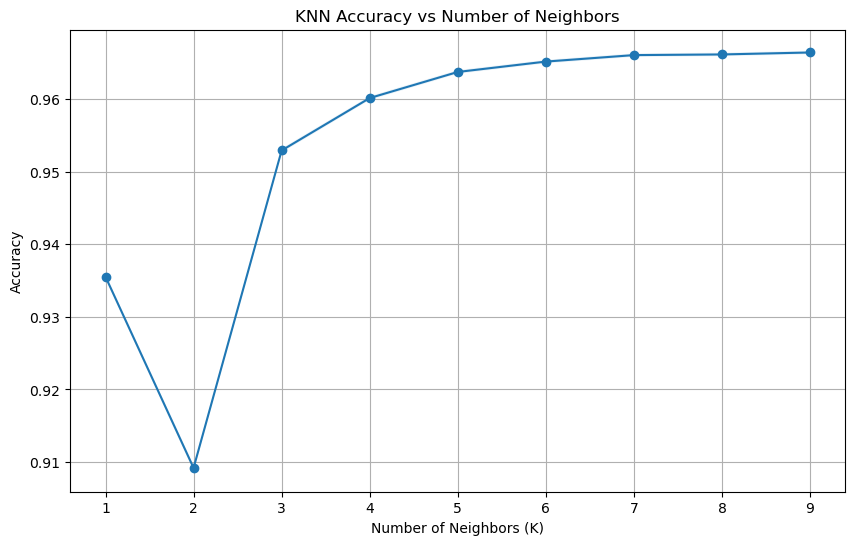

In [27]:
# KNN Accuracy vs K
Ks = 10
mean_acc = np.zeros((Ks-1))
std_acc = np.zeros((Ks-1))
for n in range(1, Ks):
    model = KNeighborsClassifier(n_neighbors=n).fit(X_train_scaled, y_train)
    yhat = model.predict(X_test_scaled)
    mean_acc[n-1] = accuracy_score(y_test, yhat)
    std_acc[n-1] = np.std(yhat == y_test) / np.sqrt(yhat.shape[0])

plt.figure(figsize=(10,6))
plt.plot(range(1, Ks), mean_acc, marker='o')
plt.fill_between(range(1, Ks), mean_acc - std_acc, mean_acc + std_acc, alpha=0.1)
plt.title('KNN Accuracy vs Number of Neighbors')
plt.xlabel('Number of Neighbors (K)')
plt.ylabel('Accuracy')
plt.grid(True)
plt.show()

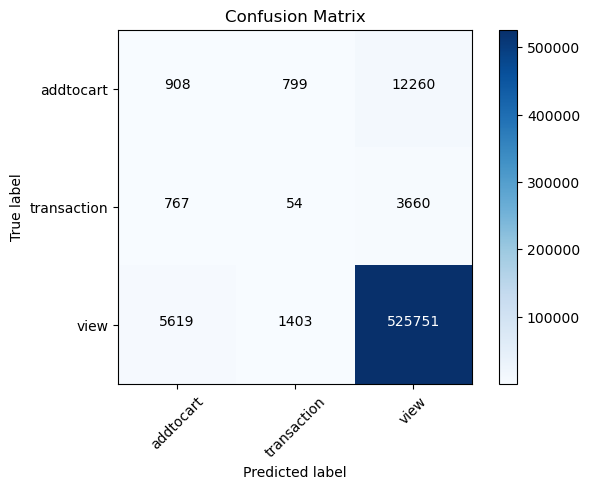

In [28]:
# Confusion Matrix
cnf_matrix = confusion_matrix(y_test, y_pred_rf)

def plot_confusion_matrix(cm, classes, title='Confusion Matrix', cmap=plt.cm.Blues):
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)
    fmt = 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt), horizontalalignment='center',
                 color='white' if cm[i, j] > thresh else 'black')
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.show()

plot_confusion_matrix(cnf_matrix, classes=le.classes_)

In [29]:
# Jaccard Score
print('Jaccard Score:', jaccard_score(y_test, y_pred_rf, average='weighted'))

# Log Loss
probs = rf_model.predict_proba(X_test_scaled)
print('Log Loss:', log_loss(y_test, probs))

Jaccard Score: 0.9273158313035453
Log Loss: 0.5858551046524039


In [30]:
# TensorFlow Recommendation Model
user_input = Input(shape=(1,), name='user_input')
item_input = Input(shape=(1,), name='item_input')

num_users = df['visitorid'].nunique() + 1
num_items = df['itemid'].nunique() + 1

embedding_dim = 32

user_embedding = Embedding(input_dim=num_users, output_dim=embedding_dim, input_length=1)(user_input)
item_embedding = Embedding(input_dim=num_items, output_dim=embedding_dim, input_length=1)(item_input)

user_vec = Flatten()(user_embedding)
item_vec = Flatten()(item_embedding)

merged = Concatenate()([user_vec, item_vec])
dense = Dense(64, activation='relu')(merged)
output = Dense(1, activation='sigmoid')(dense)

rec_model = Model(inputs=[user_input, item_input], outputs=output)
rec_model.compile(optimizer=Adam(learning_rate=0.001), loss='binary_crossentropy', metrics=['accuracy'])

rec_data = df.copy()
rec_data['label'] = (rec_data['event'] == le.transform(['transaction'])[0]).astype(int)
rec_data = rec_data[['visitorid', 'itemid', 'label']].drop_duplicates()

rec_model.fit([rec_data['visitorid'], rec_data['itemid']], rec_data['label'], epochs=2, batch_size=512, verbose=1)

# TensorFlow recommendation inference
def get_tf_recommendations(user_id, candidate_items):
    user_array = np.full(len(candidate_items), user_id)
    item_array = np.array(candidate_items)
    preds = rec_model.predict([user_array, item_array]).ravel()
    top_indices = np.argsort(-preds)[:5]
    top_items = item_array[top_indices]
    top_probs = preds[top_indices]
    return list(zip(top_items, top_probs))

recommendations = get_tf_recommendations(100, [1010, 2020, 3030, 4040, 5050, 6060])
print("Top 5 Recommendations using TensorFlow Model:")
for item_id, prob in recommendations:
    print(f"Item {item_id}, Probability={prob:.4f}")


/opt/anaconda3/lib/python3.12/site-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(
2025-04-05 12:50:20.773832: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M4
2025-04-05 12:50:20.774082: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 16.00 GB
2025-04-05 12:50:20.774086: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 5.33 GB
2025-04-05 12:50:20.774275: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2025-04-05 12:50:20.774284: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


Epoch 1/2


2025-04-05 12:50:21.914552: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:117] Plugin optimizer for device_type GPU is enabled.
2025-04-05 12:50:21.917620: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] PluggableGraphOptimizer failed: INVALID_ARGUMENT: Failed to deserialize the `graph_buf`.


4231/4231 ━━━━━━━━━━━━━━━━━━━━ 715s 168ms/step - accuracy: 0.9883 - loss: 0.1142
Epoch 2/2
4231/4231 ━━━━━━━━━━━━━━━━━━━━ 710s 168ms/step - accuracy: 0.9900 - loss: 0.0395
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 178ms/step
Top 5 Recommendations using TensorFlow Model:
Item 6060, Probability=0.0067
Item 5050, Probability=0.0056
Item 1010, Probability=0.0053
Item 3030, Probability=0.0042
Item 2020, Probability=0.0037


2025-04-05 13:14:06.692848: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] PluggableGraphOptimizer failed: INVALID_ARGUMENT: Failed to deserialize the `graph_buf`.
